In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard library imports.

# Related third party imports.
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Local application/library specific imports.
from src.models.network_operator import NetworkOperator
from src.models.network_simulation import NetworkSimulation
import src.data.graph_utilities as gu

In [3]:
g = nx.read_gml(path='../data/processed/networks/26_usa.gml', label='id')
latency_matrix = gu.create_latency_matrix(g)
max_latency = np.amax(latency_matrix)
print("Max distance: ", np.amax(latency_matrix))
print("Min Max distance:", np.amin(np.amax(latency_matrix, axis=1)))

Max distance:  4759
Min Max distance: 2624


In [22]:
factor = 0.1
ml = max_latency * factor
ns = NetworkSimulation('26_usa', **{'max_length':ml, 'shortest_k':16})
ns.initial_hypervisor_placement(**{'repeat':50, 'optimize':'overall coverage', 'max_length':ml})

In [25]:
for factor in np.linspace(0.1, 0.8, 8):
    ml = max_latency * factor
    ns = NetworkSimulation('26_usa', **{'max_length':ml, 'shortest_k':16})
    ns.initial_hypervisor_placement(**{'repeat':50, 'optimize':'overall coverage', 'max_length':ml})
    for rs in range(2,11):
        ns.discard_old_vSDNs(all=True)
        ns.generate_new_vSDN_requests(2000, rs, 10)
        ns.setup_new_vSDN_requests(rs, ml, factor)

0.1 475.90000000000003 2 26 0.393 0.0 193.03203505720782 0 424.07473714858844
0.1 475.90000000000003 3 26 0.2 0.0 232.17257787372975 0 424.07473714858844
0.1 475.90000000000003 4 26 0.0405 0.0 268.09921975168004 0 424.07473714858844
0.1 475.90000000000003 5 26 0.001 0.0 292.6909476303143 0 424.07473714858844
0.1 475.90000000000003 6 26 0.0 nan nan nan nan
0.1 475.90000000000003 7 26 0.0 nan nan nan nan
0.1 475.90000000000003 8 26 0.0 nan nan nan nan
0.1 475.90000000000003 9 26 0.0 nan nan nan nan
0.1 475.90000000000003 10 26 0.0 nan nan nan nan
0.2 951.8000000000001 2 23 0.8865 68.52684910112869 507.90089234466615 797.0870093837284 948.6557540708732
0.2 951.8000000000001 3 23 0.717 60.422604383546826 493.3630420575869 797.0870093837284 948.6557540708732
0.2 951.8000000000001 4 23 0.433 63.57384027583848 499.9826155968129 797.0870093837284 948.6557540708732
0.2 951.8000000000001 5 23 0.243 67.42202381676096 505.32286747558686 797.0870093837284 948.6557540708732
0.2 951.8000000000001 6 2

In [17]:
# fig, ax = plt.subplots(9, 1, figsize=(12, 9*9))
controller_usage = [np.zeros((len(g.nodes()),), dtype=int), np.zeros((len(g.nodes()),), dtype=int)]

for j,factor in enumerate([0.5, 0.3]):
    ml = max_latency * factor
    ns = NetworkSimulation('25_italy', **{'max_length':ml, 'shortest_k':16})
    ns.initital_hypervisor_placement(**{'repeat':50, 'select':'hypervisor count'})
    for idx, rs in enumerate(range(2,11)):
        ns.discard_old_vSDNs(all=True)
        ns.generate_new_vSDN_requests(1000, rs, 10)
        ns.setup_new_vSDN_requests(rs, ml, factor)
        ac = ns.network_operator.get_active_controllers()
        nodes, counts = np.unique(np.asarray(ac), return_counts=True)
        for i,v in enumerate(nodes):
            controller_usage[j][v] += counts[i]
        # ax[idx].bar(nodes, counts)

0.5 793.0 2 6 0.884 480.03302429167803 657.3726177926476 774.2251324211792 790.5288377275818
0.5 793.0 3 6 0.761 464.65326112699034 628.7119445870206 774.2251324211792 790.5288377275818
0.5 793.0 4 6 0.765 468.86461296831754 618.5372635746076 774.2251324211792 790.5288377275818
0.5 793.0 5 6 0.702 471.1973956596609 607.8417287957996 774.2251324211792 790.5288377275818
0.5 793.0 6 6 0.639 467.333816837867 594.7921082248952 774.2251324211792 790.5288377275818
0.5 793.0 7 6 0.558 459.1470167262851 586.2735574598581 774.2251324211792 790.5288377275818
0.5 793.0 8 6 0.435 457.97058584180564 583.0537266719506 774.2251324211792 790.5288377275818
0.5 793.0 9 6 0.393 457.3141750924049 581.6814805834059 774.2251324211792 790.5288377275818
0.5 793.0 10 6 0.297 460.66170946155887 583.1618416370214 774.2251324211792 790.5288377275818
0.3 475.79999999999995 2 12 0.852 152.3462126350901 321.0068700385721 440.2239194712324 471.81640694506143
0.3 475.79999999999995 3 12 0.614 140.54190207706594 311.480

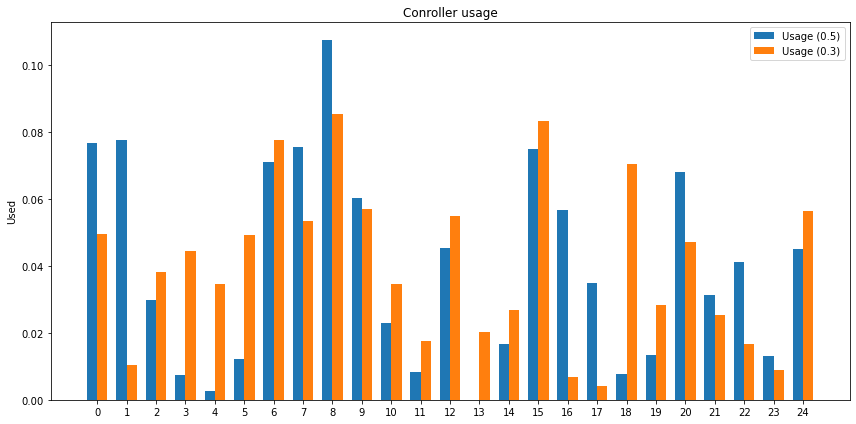

In [19]:
x = np.arange(len(g.nodes()))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, controller_usage[0]/np.sum(controller_usage[0]), width, label='Usage (0.5)')
rects2 = ax.bar(x + width/2, controller_usage[1]/np.sum(controller_usage[1]), width, label='Usage (0.3)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Used')
ax.set_title('Conroller usage')
ax.set_xticks(x)
ax.set_xticklabels(g.nodes())
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

(array([4., 3., 3., 2., 2., 3., 4., 0., 1., 3.]),
 array([0.00413437, 0.01224806, 0.02036176, 0.02847545, 0.03658915,
        0.04470284, 0.05281654, 0.06093023, 0.06904393, 0.07715762,
        0.08527132]),
 <BarContainer object of 10 artists>)

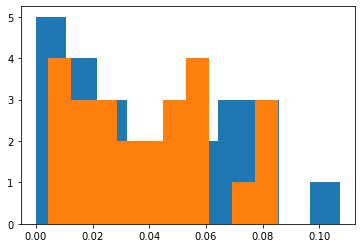

In [29]:
plt.hist(controller_usage[0]/np.sum(controller_usage[0]))
plt.hist(controller_usage[1]/np.sum(controller_usage[1]))

In [ ]:
for c, quartet_list in no.quartets_by_controllers.items():
    print(c, len(np.unique([s for _,_,_,s in quartet_list])))

In [ ]:
%time sns.countplot(x=[len(greedy(network_operator=no, start_with_pair=True)) for i in tqdm(range(13))])

In [ ]:
greedy(network_operator=no, start_with_pair=True)

In [ ]:
no.hypervisor_placement(**{'max_length':4000, 'shortest_k':10})


In [ ]:
no.hypervisor_assignment

In [ ]:
primary, backup = no.get_hypervisor_switch_latencies()

In [ ]:
no.quartets_by_controllers[0][:10]

In [ ]:
for c in no.possible_controllers:
    print(c, set(s for _,h,h_,s in no.quartets_by_controllers[c] if (h in no.active_hypervisors) and (h_ in no.active_hypervisors) ))

In [ ]:
for s in no.nodes:
    print(s, set(c for c,_,_,_ in no.quartets_by_switches[s]))